In [1]:
from torch import nn
from torch.nn import functional as F

from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data import Sampler
from torchvision.transforms import (Compose, RandomCrop, ToTensor,
                                    ToPILImage, CenterCrop, Resize)

import torch
import torchvision
import math
import numpy as np
from glob import glob

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import (
    Compose, RandomCrop, ToTensor,
    ToPILImage, CenterCrop, Resize,
    RandomHorizontalFlip, RandomVerticalFlip)
from pathlib import Path
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import os
from torch.cuda.amp import GradScaler

In [2]:
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
map_location = lambda storage, loc: storage if cuda == '' else None

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

![alt text](https://i.ibb.co/JQ9JL2t/image.png)

![alt text](https://i.ibb.co/Tcmfjjn/image.png)

## Fetching the pretrained weights

In [6]:
! wget https://raw.githubusercontent.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution/master/models.py

--2020-06-17 02:50:00--  https://raw.githubusercontent.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15130 (15K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]  14.78K  --.-KB/s    in 0.01s   

2020-06-17 02:50:01 (1.19 MB/s) - ‘models.py’ saved [15130/15130]



## Generator Model

In [7]:
class Generator(nn.Module):
    """
    """
    def __init__(self, upscale_factor=4, image_channels=3,
                 residual_block_channels=64,
                 num_residual_blocks=5):
        super().__init__()
        self.upscale_factor=upscale_factor
        self.image_channels = image_channels
        self.residual_block_channels = residual_block_channels
        self.num_residual_blocks = num_residual_blocks

        # k9n64s1
        initial_block_param = {
            "in_channels": image_channels,
            "kernel_size": 9,
            "out_channels": residual_block_channels,
            "stride": 1,
            "padding": 9 // 2
        }
        self.initial_block = nn.Sequential(
            nn.Conv2d(**initial_block_param),
            nn.PReLU()       
        )

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(channels=residual_block_channels) 
            for _ in range(num_residual_blocks)]
        )

        self.skip_block = SkipBlock(channels=residual_block_channels)

        # two trained sub-pixel convolution layers
        num_spcn_blocks = int(math.log(upscale_factor, 2))
        self.spcn_blocks = nn.Sequential(
            *[SPCNBlock(in_channels=residual_block_channels,
                       upscale_factor=2) 
            for _ in range(num_spcn_blocks)]
        )

        #  k9n3s1
        final_block_param = {
            "in_channels": residual_block_channels,
            "kernel_size": 9,
            "out_channels": image_channels,
            "stride": 1,
            "padding": 9 // 2
        }
        self.final_block = nn.Conv2d(**final_block_param)

    def forward(self, x):
        initial_out = self.initial_block(x)
        B_residual_out = self.residual_blocks(initial_out)
        skip_out = self.skip_block(B_residual_out,
                                   initial_out)
        spcn_out = self.spcn_blocks(skip_out)
        pixels = self.final_block(spcn_out)
        # tanh to squish => [-1, 1]
        # add 1          => [0, 2]
        # divide by 2    => [0, 1] 
        # out = (torch.tanh(pixels) + 1) / 2
        out = torch.tanh(pixels)

        return out
    
class ResidualBlock(nn.Module):
    """
    At the core of our very deep generator network G, which
    is illustrated in Figure 4 are B residual blocks with identical
    layout. Inspired by Johnson et al. [33] we employ the block
    layout proposed by Gross and Wilber [24]. Specifically, we
    use two convolutional layers with small 3×3 kernels and 64
    feature maps followed by batch-normalization layers [32]
    and ParametricReLU [28] as the activation function.

    k3n64s1 => 
        kernel_size = 3,
        channels = 64,
        stride = 1
    """
    
    def __init__(self, channels=64, kernel_size=3, stride=1):
        super().__init__()
        padding = 3 // 2
        self.conv1 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features=channels)
        self.prelu = nn.PReLU()

        self.conv2 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn2 = nn.BatchNorm2d(num_features=channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        # Element-wise sum
        return residual + x


class SkipBlock(nn.Module):
    """
    k3n64s1 => 
        kernel_size = 3,
        channels = 64,
        stride = 1
    """

    def __init__(self, channels=64, kernel_size=3, stride=1):
        super().__init__()
        padding = 3 // 2
        self.conv1 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features=channels)

    def forward(self, x, img):
        residual = self.conv1(x)
        residual = self.bn1(residual)

        # Element-wise sum
        return residual + img

class SPCNBlock(nn.Module):
    """
    SPCN - sub-pixel convolutional neural network
    We increase the resolution of the input image with two trained
    sub-pixel convolution layers as proposed by Shi et al. [48].

    https://arxiv.org/pdf/1609.05158.pdf

    k3n256s1 => 
        kernel_size = 3,
        channels = 256, (64 * (2 ** 2))
        stride = 1
    """
    def __init__(self, in_channels, 
                upscale_factor=2,
                kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=in_channels * (upscale_factor ** 2),
                            kernel_size=kernel_size,
                            padding=kernel_size // 2)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=upscale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)

        return x

## Assigning the pretrained weights to the Generator Model

In [8]:
checkpoint = torch.load(
    "/content/drive/My Drive/Colab Notebooks/sr/model_checkpoint/pre_trained_wandb/checkpoint_srgan.pth.tar",
    map_location=torch.device('cpu')
)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.

In [9]:
pretrained_model = checkpoint["generator"]
pretrained_model = pretrained_model.net
num_residual_blocks = len(pretrained_model.residual_blocks)

In [10]:
generator_model = Generator(num_residual_blocks=num_residual_blocks)

In [11]:
def get_num_parameters(model):
    return sum(param.numel() for param in model.parameters())

get_num_parameters(generator_model) == get_num_parameters(pretrained_model)

True

#### Copying the weights of the resuidual blocks

In [12]:
for idx in range(len(generator_model.residual_blocks)):
    from_block = pretrained_model.residual_blocks[idx]
    to_block = generator_model.residual_blocks[idx]
    
    to_block.conv1 = from_block.conv_block1.conv_block[0]
    to_block.bn1 = from_block.conv_block1.conv_block[1]
    to_block.prelu = from_block.conv_block1.conv_block[2]

    to_block.conv2 = from_block.conv_block2.conv_block[0]
    to_block.bn2 = from_block.conv_block2.conv_block[1]

In [13]:
torch.equal(
    pretrained_model.residual_blocks[0].conv_block1.conv_block[0].weight,
    generator_model.residual_blocks[0].conv1.weight
)

True

#### Copying the weights of the initial block

In [14]:
generator_model.initial_block[0] = pretrained_model.conv_block1.conv_block[0]
generator_model.initial_block[1] = pretrained_model.conv_block1.conv_block[1]

In [15]:
torch.equal(
    generator_model.initial_block[0].weight,
    pretrained_model.conv_block1.conv_block[0].weight
)

True

#### Copying the weights of the final block

In [16]:
generator_model.final_block = pretrained_model.conv_block3.conv_block[0]

In [17]:
torch.equal(
    generator_model.final_block.weight,
    pretrained_model.conv_block3.conv_block[0].weight
)

True

#### Copying the weights of the spcn block

In [18]:
for idx in range(len(pretrained_model.subpixel_convolutional_blocks)):
    from_block = pretrained_model.subpixel_convolutional_blocks[idx]
    to_block = generator_model.spcn_blocks[idx]

    to_block.conv = from_block.conv
    to_block.pixel_shuffle = from_block.pixel_shuffle
    to_block.prelu = from_block.prelu

In [19]:
torch.equal(
    generator_model.spcn_blocks[0].conv.weight,
    pretrained_model.subpixel_convolutional_blocks[0].conv.weight
)

True

#### Copying the weights of the skip block

In [20]:
generator_model.skip_block.conv1 = pretrained_model.conv_block2.conv_block[0]
generator_model.skip_block.bn1 = pretrained_model.conv_block2.conv_block[1]

In [21]:
torch.equal(
    generator_model.skip_block.conv1.weight,
    pretrained_model.conv_block2.conv_block[0].weight
)

True

In [22]:
def save_generator_checkpoint(model, filepath, is_amp=False):
    
    checkpoint = {
        'upscale_factor': model.upscale_factor,
        'image_channels': model.image_channels,
        'residual_block_channels': model.residual_block_channels,
        'num_residual_blocks': model.num_residual_blocks,
        'state_dict': model.state_dict(),
     }
    torch.save(checkpoint, filepath)


def load_generator_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Generator(checkpoint['upscale_factor'],
                      checkpoint['image_channels'],
                      checkpoint['residual_block_channels'],
                      checkpoint['num_residual_blocks'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [23]:
ps1 = (param for param in generator_model.parameters())
ps2 = (param for param in pretrained_model.parameters())

all(torch.equal(p1, p2) for p1, p2 in zip(ps1, ps2))

True

In [24]:
PATH = Path("/content/drive/My Drive/Colab Notebooks/sr/model_checkpoint/srgan_checkpoints/aishu/")
os.makedirs(PATH, exist_ok=True)
save_generator_checkpoint(generator_model, PATH / "generator_pretrianed_to_new.pth")

## Discriminator Model

In [25]:
class Discriminator(nn.Module):
    """
    We follow the architectural guidelines summarized by Radford et al. [44] 
    and use LeakyReLU activation (α = 0.2) and avoid max-pooling throughout
    the discriminator network. It contains eight convolutional layers with 
    an increasing number of 3 × 3 filter kernels, increasing by a factor of 
    2 from 64 to 512 kernels as in the VGG network [49]. 
    Strided convolutions are used to reduce the image resolution each time 
    the number of features is doubled. The resulting 512 feature maps are
    followed by two dense layers and a final sigmoid activation
    function to obtain a probability for sample classification.
    """
    def __init__(self, kernel_size=3, image_channels=3, num_middle_blocks = 7):
        super().__init__()
        self.kernel_size = kernel_size
        self.image_channels = image_channels
        self.num_middle_blocks = num_middle_blocks
        # k3n64s1
        initial_block_param = {
            "in_channels": image_channels,
            "kernel_size": kernel_size,
            "out_channels": 64,
            "stride": 1,
            "padding": kernel_size // 2
        }

        self.initial_block = nn.Sequential(
            nn.Conv2d(**initial_block_param),
            nn.LeakyReLU(0.2)
        )
        # 7 middle blocks from 64 channels to 512 channnels
        in_channels = 64
        middle_blocks = []
        for i in range(num_middle_blocks):
            if i % 2 == 0:
                stride = 2
                out_channels = in_channels
            else:
                stride = 1
                out_channels = in_channels * 2
            middle_blocks.append(
                MiddleBlock(in_channels = in_channels, 
                            out_channels = out_channels, 
                            kernel_size = kernel_size , 
                            stride=stride))
            in_channels = out_channels
        
        self.middle_blocks = nn.Sequential(*middle_blocks)
        
        # final linear layers
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))
        self.linear1 = nn.Linear(out_channels * 6 * 6, 1024)
        self.leakyRelu = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(1024, 1)

    def forward(self, x):
        batch_size = x.size(0)
        init_out = self.initial_block(x)
        mid_out = self.middle_blocks(init_out)
        out = self.adaptive_pool(mid_out)
        out = self.linear1(out.view(batch_size, -1))
        out = self.leakyRelu(out)
        out = self.linear2(out)
        return out
    
class MiddleBlock(nn.Module):
   
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.leakyRelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.leakyRelu(output)
        return output


In [26]:
kernel_size=3
image_channels=3
num_middle_blocks=7

discriminator_model = Discriminator(kernel_size=kernel_size, image_channels=image_channels, num_middle_blocks = num_middle_blocks).to(device)


## Assisgning the pretrained weights to the discriminator model

In [27]:
checkpoint = torch.load(
    "/content/drive/My Drive/Colab Notebooks/sr/model_checkpoint/pre_trained_wandb/checkpoint_srgan.pth.tar",
    map_location=torch.device('cpu')
)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.

In [28]:
pretrained_model = checkpoint["discriminator"]

In [29]:
get_num_parameters(discriminator_model) == get_num_parameters(pretrained_model)

True

#### Copying the weights of the middle blocks

In [30]:
for idx in range(len(discriminator_model.middle_blocks)):
    from_block = pretrained_model.conv_blocks[idx + 1]
    to_block = discriminator_model.middle_blocks[idx]
    to_block.conv1 = from_block.conv_block[0]
    to_block.bn1 = from_block.conv_block[1]

In [31]:
torch.equal(
    pretrained_model.conv_blocks[1].conv_block[0].weight,
    discriminator_model.middle_blocks[0].conv1.weight
)

True

#### Copying the weights of the initial block

In [32]:
discriminator_model.initial_block[0] = pretrained_model.conv_blocks[0].conv_block[0]

In [33]:
torch.equal(
    discriminator_model.initial_block[0].weight,
    pretrained_model.conv_blocks[0].conv_block[0].weight
)

True

#### Copying the weights of the final linear layers

In [34]:
discriminator_model.linear1 = pretrained_model.fc1
discriminator_model.linear2 = pretrained_model.fc2

In [35]:
torch.equal(
    discriminator_model.linear1.weight,
    pretrained_model.fc1.weight
)

True

In [36]:
def save_discriminator_checkpoint(model, filepath):
    
    checkpoint = {'kernel_size' : model.kernel_size,
                  'image_channels': model.image_channels,
                  'num_middle_blocks': model.num_middle_blocks,
                  'state_dict': model.state_dict()}

    torch.save(checkpoint, filepath)



def load_discriminator_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Generator(checkpoint['kernel_size'],
                      checkpoint['image_channels'],
                      checkpoint['num_middle_blocks'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [37]:
ps1 = (param for param in discriminator_model.parameters())
ps2 = (param for param in pretrained_model.parameters())

all(torch.equal(p1, p2) for p1, p2 in zip(ps1, ps2))

True

In [38]:
os.makedirs(PATH, exist_ok=True)
save_discriminator_checkpoint(discriminator_model, PATH / "discriminator_pretrianed_to_new.pth")

## Dataset and DataLoader

In [39]:
def max_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
    ])

def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


class SRImageDataset(Dataset):
    def __init__(self, dataset_dir, 
                 crop_size=100, 
                 upscale_factor=4):
        super().__init__()
        glob_path = str(Path(dataset_dir) / "*[.jpg, .png]")
        crop_size = max_crop_size(crop_size, upscale_factor)
        
        self.image_filenames = glob(glob_path)[:1000]
        
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [40]:
train_dataset = SRImageDataset(
    dataset_dir="/content/drive/My Drive/Colab Notebooks/sr/training_data",
    crop_size=100
)

valid_dataset = SRImageDataset(
    dataset_dir="/content/drive/My Drive/Colab Notebooks/sr/DIV2K_valid_HR",
    crop_size=500
)

In [41]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=200,
    num_workers=4
)
valid_dataloader = DataLoader(
    dataset=valid_dataset, batch_size=10,
    num_workers=4
)

len(train_dataloader), len(valid_dataloader)

(5, 10)

In [42]:
example, hr = valid_dataset[9]

In [43]:
generator = checkpoint["generator"]

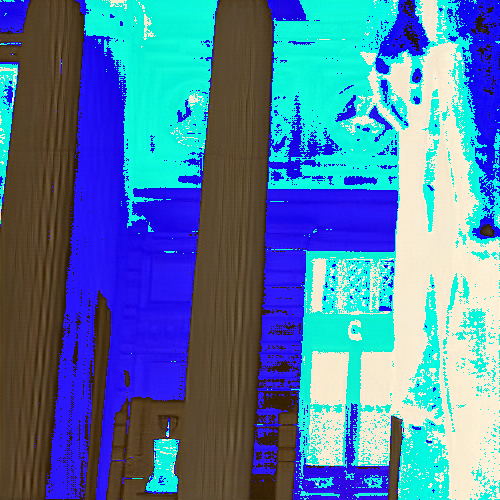

In [44]:
ToPILImage()(generator(example.unsqueeze(0).to(device)).to("cpu").squeeze(0))

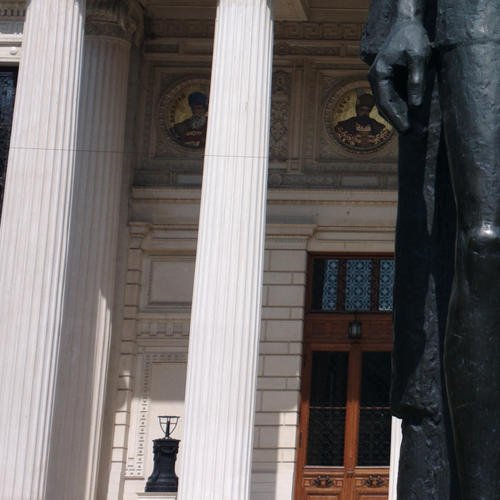

In [45]:
ToPILImage()(hr)